In [1]:
# Parameter inputs
aragorn_submit_url = "https://aragorn-u24.apps.renci.org/robokop/query"
trapi_submit_url = "http://automat-u24.apps.renci.org/robokopkg/1.3/query"

automat_cypher_submit_url = 'https://automat.renci.org/robokopkg/cypher'
robokopkg_bolt_url = "bolt://robokopkg.renci.org:7687"

input_search_string = 'ppara'
output_search_string = 'liver fibrosis'

In [2]:
import requests
import os
import json
import time
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=5)

from datetime import datetime
from pathlib import Path
from collections import Counter

In [ ]:
# Initializing directory to write
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir_trapi_automat = Path("output/compare/"+str(dt_string)+"/trapi/automat")
write_dir_trapi_automat.mkdir(parents=True, exist_ok=True)

write_dir_trapi_ara = Path("output/compare/"+str(dt_string)+"/trapi/ara")
write_dir_trapi_ara.mkdir(parents=True, exist_ok=True)

write_dir_cypher_automat = Path("output/compare/"+str(dt_string)+"/cypher/automat")
write_dir_cypher_automat.mkdir(parents=True, exist_ok=True)

write_dir_cypher_robokopkg = Path("output/compare/"+str(dt_string)+"/cypher/robokopkg")
write_dir_cypher_robokopkg.mkdir(parents=True, exist_ok=True)

In [ ]:
# Pathway results to load
ARA_results_file = "output/compare/"+str(dt_string)+"/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/"+str(dt_string)+"/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/"+str(dt_string)+"/cypher/robokopkg/results.csv"
Cypher_Automat_results_file = "output/compare/"+str(dt_string)+"/cypher/automat/results.csv"
exemplar_results_file = "output/compare/"+str(dt_string)+"/exemplar_data.csv"

In [24]:
# Pathway results to load and write directory to specify (on David's work computer from previous run)
write_dir_cypher_automat = "output/compare/2023-07-07_153233/cypher/automat"
write_dir_cypher_robokopkg = "output/compare/2023-07-07_153233/cypher/robokopkg"
ARA_results_file = "output/compare/2023-07-07_153233/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/2023-07-07_153233/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/2023-07-07_153233/cypher/robokopkg/results.csv"
Cypher_Automat_results_file = "output/compare/2023-07-07_153233/cypher/automat/results.csv"
write_dir_compare = "output/compare/2023-07-07_153233"
exemplar_results_file = "output/compare/2023-07-07_153233/exemplar_data.csv"
qbuilder_bio_entity_results_file = "output/compare/2023-07-07_153233/qbuilder_bio_entity_data.csv"
qbuilder_blank_results_file = "output/compare/2023-07-07_153233/qbuilder_blank_data.csv"
ARA_PPARA_Fibrosis_results_file = "output/compare/2023-07-07_153233/results_ARA_PPARA_Fibrosis.csv"

In [4]:
# Initializing Neo4j connection class
user = 'neo4j'
pw = ''

from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

## Generating data for comparison

### Getting "Input/Output" CURIES

In [5]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={input_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
input_node_id_list = list(results_json.keys())
print(input_node_id_list)
print(f"Number of 'input' IDs: {len(input_node_id_list)}")

['UniProtKB:P37230', 'UniProtKB:Q07869', 'UniProtKB:Q95N78', 'PR:000013056', 'UniProtKB:P23204', 'NCBIGene:19013', 'NCBIGene:25747', 'NCBIGene:5465', 'NCBIGene:557714', 'NCBIGene:30755', 'NCBIGene:563298', 'UMLS:C0166415', 'NCBIGene:10891', 'NCBIGene:133522', 'UMLS:C2984537', 'NCBIGene:400931', 'PR:000040325', 'UMLS:C1868415', 'MESH:C000630914', 'MESH:C000634429', 'UMLS:C5226508', 'UMLS:C5197094', 'UMLS:C5417797', 'REACT:R-SSC-400204', 'REACT:R-BTA-400204', 'UMLS:C1518805', 'REACT:R-DRE-400204', 'REACT:R-HSA-400204', 'REACT:R-MMU-400204', 'REACT:R-BTA-9734475', 'REACT:R-SSC-9734475', 'REACT:R-HSA-879724', 'REACT:R-DRE-9734475', 'REACT:R-HSA-9734475', 'REACT:R-CFA-400204', 'REACT:R-MMU-9734475', 'REACT:R-RNO-400204', 'REACT:R-XTR-400204', 'REACT:R-CFA-9734475', 'REACT:R-RNO-9734475', 'REACT:R-XTR-9734475', 'REACT:R-DME-400204', 'REACT:R-HSA-1989781', 'REACT:R-BTA-4341070', 'REACT:R-DME-9734475', 'REACT:R-BTA-400143', 'REACT:R-DRE-400143', 'REACT:R-DRE-4341070', 'REACT:R-MMU-400143', 'RE

In [48]:
# TO-DO- sanity check and get the preferred labels for each of these - output as table
for id, name_list in results_json.items():
    print(f"{id}: {name_list}")

UniProtKB:P37230: ['Ppara', 'Ppar', 'Nr1c1', 'rPPARA', 'PPAR-alpha (rat)', 'nuclear receptor subfamily 1 group C member 1 (rat)', 'peroxisome proliferator-activated receptor alpha (rat)']
UniProtKB:Q07869: ['PPARA', 'PPARA', 'PPAR', 'NR1C1', 'hPPARA', 'PPAR-Alpha', 'PPAR-alpha (human)', 'Nuclear Receptor Subfamily 1 Group C Member 1', 'Peroxisome Proliferator-Activated Receptor Alpha', 'nuclear receptor subfamily 1 group C member 1 (human)', 'Peroxisome Proliferator-Activated Receptor Alpha, human', 'peroxisome proliferator-activated receptor alpha (human)']
UniProtKB:Q95N78: ['PPARA', 'dog-PPARA', 'NR1C1', 'PPAR-alpha (dog)', 'nuclear receptor subfamily 1 group C member 1 (dog)', 'peroxisome proliferator-activated receptor alpha (dog)']
PR:000013056: ['PPARA', 'PPAR', 'NR1C1', 'PPAR-alpha', 'nuclear receptor subfamily 1 group C member 1', 'peroxisome proliferator-activated receptor alpha']
UniProtKB:P23204: ['Ppara', 'Ppar', 'Nr1c1', 'mPPARA', 'PPAR-alpha (mouse)', 'nuclear receptor s

In [6]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={output_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
output_node_id_list = list(results_json.keys())
print(output_node_id_list)
print(f"Number of 'output' IDs: {len(output_node_id_list)}")

['HP:0001395', 'UMLS:C4227681', 'UMLS:C4034373', 'UMLS:C5189427', 'UMLS:C0544816', 'MONDO:0100430', 'MONDO:0018840', 'UMLS:C1397317', 'UMLS:C4068302', 'UMLS:C4481250', 'UMLS:C2827436', 'UMLS:C4321337', 'UMLS:C4695229', 'UMLS:C0494791', 'UMLS:C0400961', 'UMLS:C3864238', 'UMLS:C1960658', 'UMLS:C4695228', 'UMLS:C5563662', 'UMLS:C1407032', 'UMLS:C0400925', 'UMLS:C4749320', 'UMLS:C5548949', 'UMLS:C4533463', 'UMLS:C5689517', 'UMLS:C5689516', 'UMLS:C4722044', 'UMLS:C1856310', 'UMLS:C5439238', 'UMLS:C4722043', 'UMLS:C5548946', 'UMLS:C4533767', 'UMLS:C3277942', 'UMLS:C1385044', 'UMLS:C4070891', 'UMLS:C3873179', 'UMLS:C4070890', 'UMLS:C1954436', 'UMLS:C4070622', 'UMLS:C4036765', 'UMLS:C5215514', 'UMLS:C0451713', 'UMLS:C5686432', 'UMLS:C3275636', 'UMLS:C4750548', 'UMLS:C5549445', 'UMLS:C5549441', 'UMLS:C2184113', 'UMLS:C5190480', 'UMLS:C5171263', 'UMLS:C5171261', 'UMLS:C5171262', 'UMLS:C2751577', 'UMLS:C1869017', 'UMLS:C4030819', 'UMLS:C2749679', 'UMLS:C5697513', 'UMLS:C4732266', 'UMLS:C3869480',

In [51]:
# TO-DO- sanity check and get the preferred labels for each of these - output as table
for id, name_list in results_json.items():
    print(f"{id}: {name_list[0]}")

HP:0001395: Fibrosis liver
UMLS:C4227681: Liver fibrosis, mild
UMLS:C4034373: liver fibrosis score
UMLS:C5189427: liver fibrosis stage
UMLS:C0544816: Fibrosis, septal, liver
MONDO:0100430: liver fibrosis (disease)
MONDO:0018840: congenital liver fibrosis
UMLS:C1397317: fibrosis; liver, alcoholic
UMLS:C4068302: Liver fibrosis score panel
UMLS:C4481250: biopsy liver portal fibrosis
UMLS:C2827436: Cystic Fibrosis Liver Disease
UMLS:C4321337: Enhanced Liver Fibrosis Score
UMLS:C4695229: Liver fibrosis interpretation
UMLS:C0494791: Fibrosis and cirrhosis of liver
UMLS:C0400961: fibrosis; liver, with sclerosis
UMLS:C3864238: abdominal ultrasound liver fibrosis
UMLS:C1960658: Liver disease due to cystic fibrosis
UMLS:C4695228: Liver fibrosis interpretation Ser-Imp
UMLS:C5563662: Periportal fibrosis seen on liver biopsy
UMLS:C1407032: toxic; disorders of liver, with fibrosis
UMLS:C0400925: alcoholic sclerosis and fibrosis of liver
UMLS:C4749320: Liver transient elastography fibrosis score
UMLS

### TRAPI methods

In [ ]:
# Initializing TRAPI query and extracting results for ARA and Automat
query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": input_node_id_list, #['NCBIGene:5465'], #
            "categories": ["biolink:GeneOrGeneProduct"]
          },
          "n01": {
              "categories": ["biolink:BiologicalEntity"]
          },
          "n02": {
            "ids": output_node_id_list, #["HP:0001395"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }


In [ ]:
response_trapi = requests.post(trapi_submit_url,json=query)
print(response_trapi.status_code)
number_pathway_results_trapi = len(response_trapi.json()['message']['results'])
print(len(response_trapi.json()['message']['results']))

In [ ]:
kg_trapi = response_trapi.json()['message']['knowledge_graph']
results_trapi = response_trapi.json()['message']['results']

In [ ]:
import pandas as pd
import os

cols = []
for node in sorted(results_trapi[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_trapi_df = pd.DataFrame(columns = cols)

results_trapi_list = []
for result in results_trapi:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg_trapi['nodes'][node_id]['name']

    results_trapi_list.append(pd.DataFrame([result_dict]))
results_trapi_df = pd.concat(results_trapi_list)
display(results_trapi_df)
# results_trapi_df.to_csv(os.path.join(write_dir_trapi_automat,'results_TRAPI.csv'), index=False)
results_trapi_df.to_csv(TRAPI_results_file, index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_trapi_df[cols].to_numpy()]
pp.pprint(combined_node_list)

In [ ]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results_trapi):
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = results_trapi[i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = kg_trapi['edges'][edge_id]['subject']
                subject = kg_trapi['nodes'][subject_id]['name']
                predicate = kg_trapi['edges'][edge_id]['predicate']
                object_id = kg_trapi['edges'][edge_id]['object']
                object = kg_trapi['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir_trapi_automat,combined_node_list[i]+".txt"), 'a') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

In [ ]:
response_ara = requests.post(aragorn_submit_url,json=query)
print(response_ara.status_code)
number_pathway_results_ara = len(response_ara.json()['message']['results'])
print(len(response_ara.json()['message']['results']))

In [ ]:
kg_ara = response_ara.json()['message']['knowledge_graph']
results_ara = response_ara.json()['message']['results']

In [ ]:
import pandas as pd
import os

cols = []
for node in sorted(results_ara[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_ara_df = pd.DataFrame(columns = cols)

results_ara_list = []
for result in results_ara:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg_ara['nodes'][node_id]['name']

    results_ara_list.append(pd.DataFrame([result_dict]))
results_ara_df = pd.concat(results_ara_list)
display(results_ara_df)
# results_ara_df.to_csv(os.path.join(write_dir_trapi_ara,'results_ARA.csv'), index=False)
results_ara_df.to_csv(ARA_results_file, index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_ara_df[cols].to_numpy()]
pp.pprint(combined_node_list)

In [ ]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results_ara):
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = results_ara[i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = kg_ara['edges'][edge_id]['subject']
                subject = kg_ara['nodes'][subject_id]['name']
                predicate = kg_ara['edges'][edge_id]['predicate']
                object_id = kg_ara['edges'][edge_id]['object']
                object = kg_ara['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir_trapi_ara,combined_node_list[i]+".txt"), 'a') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

### Cypher methods

In [53]:
# Initializing Cypher query and extracting results from Automat using Cypher

nodes = ['n00','n01','n02']
cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

i = 0
for input_node_id in input_node_id_list:
    if i > 0:
        break
    for output_node_id in output_node_id_list:
        if i > 0:
            break
        cypher = f"""MATCH ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[r0_0]-({nodes[1]}:`biolink:BiologicalEntity`)-[r1_0]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`) 
        WHERE {nodes[0]}.id IN ['{input_node_id}'] AND {nodes[2]}.id IN ['{output_node_id}'] 
        RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, 
        [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, 
        [{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
        [{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 100"""
        # print(f"{input_node_id}-{output_node_id}")
        json_query = {'query': cypher}
        # TO-DO:
        # - change timeout value for API call
        # - add sleep call (30s to 60s) at end of each iteration of loop
        for z in range(10):
            try:
                results = requests.post(automat_cypher_submit_url,json=json_query, timeout=(40,200))
            except requests.ConnectionError as connect_error:
                print(f"ConnectionError caught, attempt {z+1}, sleeping 60 seconds then re-posting...")
                time.sleep(60)
                if z == 10:
                    print(f"Maximum connection attempts reached, stopped at: {input_node_id}-{output_node_id}")
                continue
            try:
                results_json = results.json()
            except json.decoder.JSONDecodeError as json_error:
                print(f"JSON Decode Error: {input_node_id}-{output_node_id}")
            break
                # results = requests.post(automat_cypher_submit_url,json=j, timeout=(40,200))
        # print(results.status_code)
        
        # try:
        #     results_json = results.json()
        # except json.decoder.JSONDecodeError:
        #     print(f"JSON Decode Error: {input_node_id}-{output_node_id}")
            
        string_out_list = []
        # pp.pprint(results_json)
        for result in results_json['results'][0]['data']:
            for item in result['row'][0:2]:
                string_out = f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}||{item[1][1]}"
                if string_out not in string_out_list:
                    string_out_list.append(string_out)
        if len(results_json['results'][0]['data']) > 0:
            combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
            # print(combined_node_list)

        string_out_list = [i.split('||', 1)[0] for i in string_out_list]

        string_out_dict = dict(Counter(string_out_list).items())
        if len(string_out_dict.keys()) == 0:
            pass
            # print(f"None found for {input_node_id}-{output_node_id}")
        else:
            combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
            print(combined_node_list)

            string_out_list = [i.split('||', 1)[0] for i in string_out_list]

            string_out_dict = dict(Counter(string_out_list).items())
            pp.pprint(string_out_dict)
            # i = i + 1

            with open(os.path.join(write_dir_cypher_automat,combined_node_list+".txt"), 'a') as convert_file:
                convert_file.write(json.dumps(string_out_dict))
            
            result_dict = {}
            for k in range(len(nodes)):
                node_id = results_json['results'][0]['data'][0]['row'][3][k]
                node_name = results_json['results'][0]['data'][0]['row'][2][k]
                result_dict[nodes[k]] = node_id
                result_dict[nodes[k]+"_name"] = node_name
            pp.pprint(result_dict)

            results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
# results_df.to_csv(os.path.join(write_dir_cypher_automat,'results.csv'))
results_df.to_csv(Cypher_Automat_results_file)

PPARA_CCN2_Hepatic_fibrosis
{    'ABCB4 -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'AGT -> biolink:affects -> PPARA': 1,
     'AGT -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'ALB -> biolink:affects -> PPARA': 1,
     'ALB -> biolink:directly_physically_interacts_with -> PPARA': 1,
     'ALB -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'ARNT -> biolink:affects -> PPARA': 1,
     'ARNT -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'ARRB1 -> biolink:affects -> PPARA': 1,
     'ARRB1 -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'CCL2 -> biolink:affects -> PPARA': 1,
     'CCL2 -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'CCN2 -> biolink:affects -> PPARA': 1,
     'CCN2 -> biolink:genetically_associated_with -> Hepatic fibrosis': 1,
     'CNR2 -> biolink:affects -> PPARA': 1,
     'CNR2 -> biolink:genetically_associated_with -> Hepatic fibrosis'

In [ ]:
# Saving results if above failed
results_df = pd.DataFrame(columns = cols)
results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
# results_df.to_csv(os.path.join(write_dir_cypher_automat,'results.csv'))
results_df.to_csv(Cypher_Automat_results_file)

In [ ]:
# Initializing Cypher query and extracting results from ROBOKOPKG using Bolt protocol method
conn = Neo4jConnection(uri=robokopkg_bolt_url, user = user, pwd = pw)

nodes = ['n00','n01','n02']

cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

i = 0
for input_node_id in input_node_id_list:
    if i > 0:
        break
    for output_node_id in output_node_id_list:
        if i > 0:
            break
        cypher = f"""MATCH ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[r0_0]-({nodes[1]}:`biolink:BiologicalEntity`)-[r1_0]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`) 
        WHERE {nodes[0]}.id IN ['{input_node_id}'] AND {nodes[2]}.id IN ['{output_node_id}'] 
        RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, 
        [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, 
        [{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
        [{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 100"""
        record_list = conn.query(cypher)
        
        string_out_list = []
        for record in record_list: 
            record_data = record.data()
            #only grab the edge information and skip the node names and IDs
            record_data_first2 = {k: record_data[k] for k in list(record_data)[:2]}
            for label, data in record_data_first2.items():
                string_out = f"{label} - {data[0]['name']} -> {data[1][0]} -> {data[2]['name']}||{data[1][1]}"
                if string_out not in string_out_list:
                    string_out_list.append(string_out)

        if len(record_list) > 0:
            combined_node_list = "_".join(list(record_list[0].data('node_names').values())[0])
            print(combined_node_list)

            string_out_list = [i.split('||', 1)[0] for i in string_out_list]

            string_out_dict = dict(Counter(string_out_list).items())
            pp.pprint(string_out_dict)

            with open(os.path.join(write_dir_cypher_robokopkg,combined_node_list+".txt"), 'a') as convert_file:
                convert_file.write(json.dumps(string_out_dict))
        
        for record in record_list:
            # print(f"{input_node_id} - {output_node_id}")
            record_data = record.data()
            #only grab the node labels and IDs
            record_data_last2 = {k: record_data[k] for k in list(record_data)[2:]}

            result_dict = {}
            for label, data in record_data_last2.items():
                # print(f"{label}: {data}")
                for j in range(len(nodes)):
                    if "ids" in label:
                        node_id = data[j]
                        result_dict[nodes[j]] = node_id
                    elif "names" in label:
                        node_name = data[j]
                        result_dict[nodes[j]+"_name"] = node_name
            # pp.pprint(result_dict)

            results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
display(results_df)
# results_df.to_csv(os.path.join(write_dir_cypher_robokopkg,'results.csv'))
results_df.to_csv(Cypher_ROBOKOPKG_results_file)
conn.close()

In [37]:
import pandas as pd
pd.options.display.max_colwidth = 100

def get_summary_stats(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02": "first","n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00", "n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "n02": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 IDs")
    display(occur_n00)
    print("\nFrequency of n02 IDs")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair IDs")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def get_summary_stats_no_ids(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00_name", "n02_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00_name": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 labels")
    display(occur_n00)
    print("\nFrequency of n02 labels")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair labels")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def compare_summary_stats(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)
    
def compare_summary_stats_no_ids(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats_no_ids(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats_no_ids(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)

In [ ]:
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
display(results_df_Cypher_Automat)
most_common_pair_test = get_summary_stats(results_df_Cypher_Automat)

## TRAPI comparison results
ARA vs TRAPI

In [ ]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
compare_summary_stats(results_df_ARA,results_df_TRAPI,"ARA","TRAPI (automat)")

In [38]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
compare_summary_stats(results_df_ARA,results_df_Cypher_ROBOKOPKG,"ARA","Cypher (ROBOKOPKG)")

Summary stats for ARA

Frequency of n00 IDs


,n00,n00_name,Freq
0,NCBIGene:5465,PPARA,112
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),39
2,NCBIGene:10891,PPARGC1A,22
3,NCBIGene:133522,PPARGC1B,18
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),5
5,NCBIGene:80205,CHD9,4
6,UniProtKB:Q3L8U1-2,chromodomain-helicase-DNA-binding protein 9 isoform h2 (human),1



Frequency of n02 IDs


,n02,n02_name,Freq
0,HP:0001395,Hepatic fibrosis,133
1,MONDO:0018840,isolated congenital hepatic fibrosis,60
2,HP:0001405,Periportal fibrosis,2
3,HP:0012852,Hepatic bridging fibrosis,2
4,MONDO:0100430,fibrotic liver disease,2
5,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,2



Frequency of n00-n02 pair IDs


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68
1,NCBIGene:5465,PPARA,MONDO:0018840,isolated congenital hepatic fibrosis,36
2,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),HP:0001395,Hepatic fibrosis,33
3,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,14
4,NCBIGene:133522,PPARGC1B,HP:0001395,Hepatic fibrosis,12
5,NCBIGene:10891,PPARGC1A,MONDO:0018840,isolated congenital hepatic fibrosis,8
6,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),MONDO:0018840,isolated congenital hepatic fibrosis,6
7,NCBIGene:133522,PPARGC1B,MONDO:0018840,isolated congenital hepatic fibrosis,6
8,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),HP:0001395,Hepatic fibrosis,3
9,NCBIGene:80205,CHD9,MONDO:0018840,isolated congenital hepatic fibrosis,2



Most frequent pair


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68



Summary stats for Cypher (ROBOKOPKG)

Frequency of n00 IDs


,n00,n00_name,Freq
0,NCBIGene:5465,PPARA,80
1,NCBIGene:10891,PPARGC1A,23
2,NCBIGene:133522,PPARGC1B,21
3,NCBIGene:80205,CHD9,3



Frequency of n02 IDs


,n02,n02_name,Freq
0,HP:0001395,Hepatic fibrosis,99
1,MONDO:0018840,isolated congenital hepatic fibrosis,24
2,MONDO:0100430,fibrotic liver disease,2
3,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,2



Frequency of n00-n02 pair IDs


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,60
1,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,19
2,NCBIGene:133522,PPARGC1B,HP:0001395,Hepatic fibrosis,18
3,NCBIGene:5465,PPARA,MONDO:0018840,isolated congenital hepatic fibrosis,16
4,NCBIGene:10891,PPARGC1A,MONDO:0018840,isolated congenital hepatic fibrosis,4
5,NCBIGene:133522,PPARGC1B,MONDO:0018840,isolated congenital hepatic fibrosis,3
6,NCBIGene:80205,CHD9,HP:0001395,Hepatic fibrosis,2
7,NCBIGene:5465,PPARA,MONDO:0100430,fibrotic liver disease,2
8,NCBIGene:5465,PPARA,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,2
9,NCBIGene:80205,CHD9,MONDO:0018840,isolated congenital hepatic fibrosis,1



Most frequent pair


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,60


,n00,n00_name,n02,n02_name,Freq,label
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68,ARA
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,60,Cypher (ROBOKOPKG)


## Cypher comparison results
Automat vs ROBOKOPKG

In [ ]:
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
compare_summary_stats(results_df_Cypher_Automat,results_df_Cypher_ROBOKOPKG,"Cypher (automat)","Cypher (ROBOKOPKG)")

ExEmPLAR vs ROBOKOPKG

In [41]:
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
results_df_exemplar = pd.read_csv(exemplar_results_file)
compare_summary_stats_no_ids(results_df_exemplar,results_df_Cypher_ROBOKOPKG,"ExEmPLAR","Cypher (ROBOKOPKG)")

Summary stats for ExEmPLAR

Frequency of n00 labels


,n00_name,Freq
0,PPARA,56
1,PPARGC1A,18
2,PPARGC1B,15
3,CHD9,3



Frequency of n02 labels


,n02_name,Freq
0,Hepatic fibrosis,68
1,isolated congenital hepatic fibrosis,20
2,Liver Disease Associated with Cystic Fibrosis,2
3,fibrotic liver disease,2



Frequency of n00-n02 pair labels


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,40
1,PPARGC1A,Hepatic fibrosis,14
2,PPARGC1B,Hepatic fibrosis,12
3,PPARA,isolated congenital hepatic fibrosis,12
4,PPARGC1A,isolated congenital hepatic fibrosis,4
5,PPARGC1B,isolated congenital hepatic fibrosis,3
6,CHD9,Hepatic fibrosis,2
7,PPARA,Liver Disease Associated with Cystic Fibrosis,2
8,PPARA,fibrotic liver disease,2
9,CHD9,isolated congenital hepatic fibrosis,1



Most frequent pair


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,40



Summary stats for Cypher (ROBOKOPKG)

Frequency of n00 labels


,n00_name,Freq
0,PPARA,80
1,PPARGC1A,23
2,PPARGC1B,21
3,CHD9,3



Frequency of n02 labels


,n02_name,Freq
0,Hepatic fibrosis,99
1,isolated congenital hepatic fibrosis,24
2,Liver Disease Associated with Cystic Fibrosis,2
3,fibrotic liver disease,2



Frequency of n00-n02 pair labels


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,60
1,PPARGC1A,Hepatic fibrosis,19
2,PPARGC1B,Hepatic fibrosis,18
3,PPARA,isolated congenital hepatic fibrosis,16
4,PPARGC1A,isolated congenital hepatic fibrosis,4
5,PPARGC1B,isolated congenital hepatic fibrosis,3
6,CHD9,Hepatic fibrosis,2
7,PPARA,Liver Disease Associated with Cystic Fibrosis,2
8,PPARA,fibrotic liver disease,2
9,CHD9,isolated congenital hepatic fibrosis,1



Most frequent pair


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,60


,n00_name,n02_name,Freq,label
0,PPARA,Hepatic fibrosis,40,ExEmPLAR
0,PPARA,Hepatic fibrosis,60,Cypher (ROBOKOPKG)


## Automat comparison results
TRAPI vs Cypher

In [96]:
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
compare_summary_stats(results_df_TRAPI,results_df_Cypher_Automat,"TRAPI (automat)","Cypher (automat)")

Summary stats for TRAPI (automat)

Frequency of n00 IDs


,n00,n00_name,Freq
0,NCBIGene:5465,PPARA,112
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alp...,39
2,NCBIGene:10891,PPARGC1A,22
3,NCBIGene:133522,PPARGC1B,18
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,5
5,NCBIGene:80205,CHD9,4
6,UniProtKB:Q3L8U1-2,chromodomain-helicase-DNA-binding protein 9 is...,1



Frequency of n02 IDs


,n02,n02_name,Freq
0,HP:0001395,Hepatic fibrosis,133
1,MONDO:0018840,isolated congenital hepatic fibrosis,60
2,HP:0001405,Periportal fibrosis,2
3,HP:0012852,Hepatic bridging fibrosis,2
4,MONDO:0100430,fibrotic liver disease,2
5,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,2



Frequency of n00-n02 pair IDs


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68
1,NCBIGene:5465,PPARA,MONDO:0018840,isolated congenital hepatic fibrosis,36
2,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alp...,HP:0001395,Hepatic fibrosis,33
3,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,14
4,NCBIGene:133522,PPARGC1B,HP:0001395,Hepatic fibrosis,12
5,NCBIGene:10891,PPARGC1A,MONDO:0018840,isolated congenital hepatic fibrosis,8
6,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alp...,MONDO:0018840,isolated congenital hepatic fibrosis,6
7,NCBIGene:133522,PPARGC1B,MONDO:0018840,isolated congenital hepatic fibrosis,6
8,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gam...,HP:0001395,Hepatic fibrosis,3
9,NCBIGene:80205,CHD9,MONDO:0018840,isolated congenital hepatic fibrosis,2



Most frequent pair


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68



Summary stats for Cypher (automat)

Frequency of n00 IDs


,n00,n00_name,Freq
0,NCBIGene:5465,PPARA,4
1,NCBIGene:10891,PPARGC1A,2
2,NCBIGene:133522,PPARGC1B,2
3,NCBIGene:80205,CHD9,2



Frequency of n02 IDs


,n02,n02_name,Freq
0,HP:0001395,Hepatic fibrosis,4
1,MONDO:0018840,isolated congenital hepatic fibrosis,4
2,MONDO:0100430,fibrotic liver disease,1
3,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,1



Frequency of n00-n02 pair IDs


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,1
1,NCBIGene:133522,PPARGC1B,HP:0001395,Hepatic fibrosis,1
2,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,1
3,NCBIGene:80205,CHD9,HP:0001395,Hepatic fibrosis,1
4,NCBIGene:10891,PPARGC1A,MONDO:0018840,isolated congenital hepatic fibrosis,1
5,NCBIGene:133522,PPARGC1B,MONDO:0018840,isolated congenital hepatic fibrosis,1
6,NCBIGene:5465,PPARA,MONDO:0018840,isolated congenital hepatic fibrosis,1
7,NCBIGene:80205,CHD9,MONDO:0018840,isolated congenital hepatic fibrosis,1
8,NCBIGene:5465,PPARA,MONDO:0100430,fibrotic liver disease,1
9,NCBIGene:5465,PPARA,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,1



Most frequent pair


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,1


,n00,n00_name,n02,n02_name,Freq,label
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68,TRAPI (automat)
0,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,1,Cypher (automat)


## Question Builder comparison

Question builder with and without "BiologicalEntity" as the intermediate node

In [101]:
results_df_qbuilder_bio_entity = pd.read_csv(qbuilder_bio_entity_results_file)
results_df_qbuilder_blank = pd.read_csv(qbuilder_blank_results_file)
compare_summary_stats_no_ids(results_df_qbuilder_bio_entity,results_df_qbuilder_blank,"Question Builder (BiologicalEntity)","Question Builder")

Summary stats for Question Builder (BiologicalEntity)

Frequency of n00 labels


,n00_name,Freq
0,PPARA,45
1,peroxisome proliferator-activated receptor alp...,12



Frequency of n02 labels


,n02_name,Freq
0,Hepatic fibrosis,45
1,isolated congenital hepatic fibrosis,10
2,Hepatic bridging fibrosis,1
3,Periportal fibrosis,1



Frequency of n00-n02 pair labels


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,34
1,peroxisome proliferator-activated receptor alp...,Hepatic fibrosis,11
2,PPARA,isolated congenital hepatic fibrosis,9
3,PPARA,Hepatic bridging fibrosis,1
4,PPARA,Periportal fibrosis,1
5,peroxisome proliferator-activated receptor alp...,isolated congenital hepatic fibrosis,1



Most frequent pair


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,34



Summary stats for Question Builder

Frequency of n00 labels


,n00_name,Freq
0,PPARA,65
1,peroxisome proliferator-activated receptor alp...,12



Frequency of n02 labels


,n02_name,Freq
0,Hepatic fibrosis,60
1,isolated congenital hepatic fibrosis,15
2,Hepatic bridging fibrosis,1
3,Periportal fibrosis,1



Frequency of n00-n02 pair labels


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,49
1,PPARA,isolated congenital hepatic fibrosis,14
2,peroxisome proliferator-activated receptor alp...,Hepatic fibrosis,11
3,PPARA,Hepatic bridging fibrosis,1
4,PPARA,Periportal fibrosis,1
5,peroxisome proliferator-activated receptor alp...,isolated congenital hepatic fibrosis,1



Most frequent pair


,n00_name,n02_name,Freq
0,PPARA,Hepatic fibrosis,49


,n00_name,n02_name,Freq,label
0,PPARA,Hepatic fibrosis,34,Question Builder (BiologicalEntity)
0,PPARA,Hepatic fibrosis,49,Question Builder


## Comparison plots

In [25]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
results_df_exemplar = pd.read_csv(exemplar_results_file)
results_df_qbuilder_bio_entity = pd.read_csv(qbuilder_bio_entity_results_file)
results_df_qbuilder_blank = pd.read_csv(qbuilder_blank_results_file)
results_df_ARA_PPARA_Fibrosis = pd.read_csv(ARA_PPARA_Fibrosis_results_file)

In [7]:
display(results_df_ARA)

,n00,n00_name,n01,n01_name,n02,n02_name
0,NCBIGene:5465,PPARA,NCBIGene:4088,SMAD3,HP:0001395,Hepatic fibrosis
1,NCBIGene:5465,PPARA,NCBIGene:4088,SMAD3,HP:0001395,Hepatic fibrosis
2,NCBIGene:5465,PPARA,NCBIGene:7040,TGFB1,HP:0001395,Hepatic fibrosis
3,NCBIGene:5465,PPARA,NCBIGene:7040,TGFB1,HP:0001395,Hepatic fibrosis
4,NCBIGene:5465,PPARA,NCBIGene:6347,CCL2,HP:0001395,Hepatic fibrosis
...,...,...,...,...,...,...
196,NCBIGene:10891,PPARGC1A,NCBIGene:3066,HDAC2,HP:0001395,Hepatic fibrosis
197,NCBIGene:80205,CHD9,NCBIGene:183,AGT,MONDO:0018840,isolated congenital hepatic fibrosis
198,NCBIGene:80205,CHD9,NCBIGene:183,AGT,MONDO:0018840,isolated congenital hepatic fibrosis
199,NCBIGene:80205,CHD9,NCBIGene:5244,ABCB4,HP:0001395,Hepatic fibrosis


In [14]:
df1 = results_df_ARA
df2 = results_df_qbuilder_blank

df=pd.concat([df1, df2],axis=1, keys = ['df1', 'df2'])
# display(df)
display(df[(df['df1']['n00_name']==df['df2']['n00_name'])&(df['df1']['n01_name']==df['df2']['n01_name'])&(df['df1']['n02_name']==df['df2']['n02_name'])])


df1                                               \
             n00 n00_name            n01 n01_name         n02   
1  NCBIGene:5465    PPARA  NCBIGene:4088    SMAD3  HP:0001395   
2  NCBIGene:5465    PPARA  NCBIGene:7040    TGFB1  HP:0001395   

                         df2                                    
           n02_name n00_name n01_name          n02_name  Score  
1  Hepatic fibrosis    PPARA    SMAD3  Hepatic fibrosis  0.426  
2  Hepatic fibrosis    PPARA    TGFB1  Hepatic fibrosis  0.422

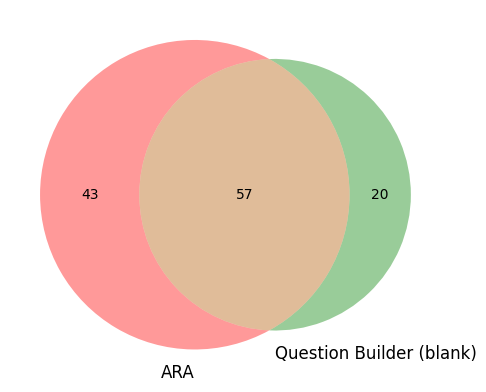

Number of common pathways: 57
Number pathways in ARA alone: 43
Number pathways in Question Builder (blank) alone: 20


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_21588\264315744.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_21588\264315744.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,ARA,Question Builder (blank)
PPARGC1B|HNF1A|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1B|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|HNF1A|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1B|REN|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|REN|isolated congenital hepatic fibrosis,2.0,0.0
peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARA|liver disorder|Liver Disease Associated with Cystic Fibrosis,2.0,0.0
PPARA|liver disorder|fibrotic liver disease,2.0,0.0
CHD9|AGT|isolated congenital hepatic fibrosis,2.0,0.0


,ARA,Question Builder (blank)
PPARA|Ethanol|Hepatic fibrosis,0.0,1.0
PPARA|Hydrogen Peroxide|Hepatic fibrosis,0.0,1.0
PPARA|Azathioprine|isolated congenital hepatic fibrosis,0.0,1.0
PPARA|Copper|isolated congenital hepatic fibrosis,0.0,1.0
PPARA|Mycophenolic acid|Hepatic fibrosis,0.0,1.0
"PPARA|(2S,3S,4R,5R)-2,3,4,5,6-pentahydroxyhexanal|isolated congenital hepatic fibrosis",0.0,1.0
PPARA|Zidovudine|Hepatic fibrosis,0.0,1.0
PPARA|Venlafaxine|Hepatic fibrosis,0.0,1.0
PPARA|Stavudine|Hepatic fibrosis,0.0,1.0
PPARA|Lamivudine|Hepatic fibrosis,0.0,1.0


(-3.0, 3.0)

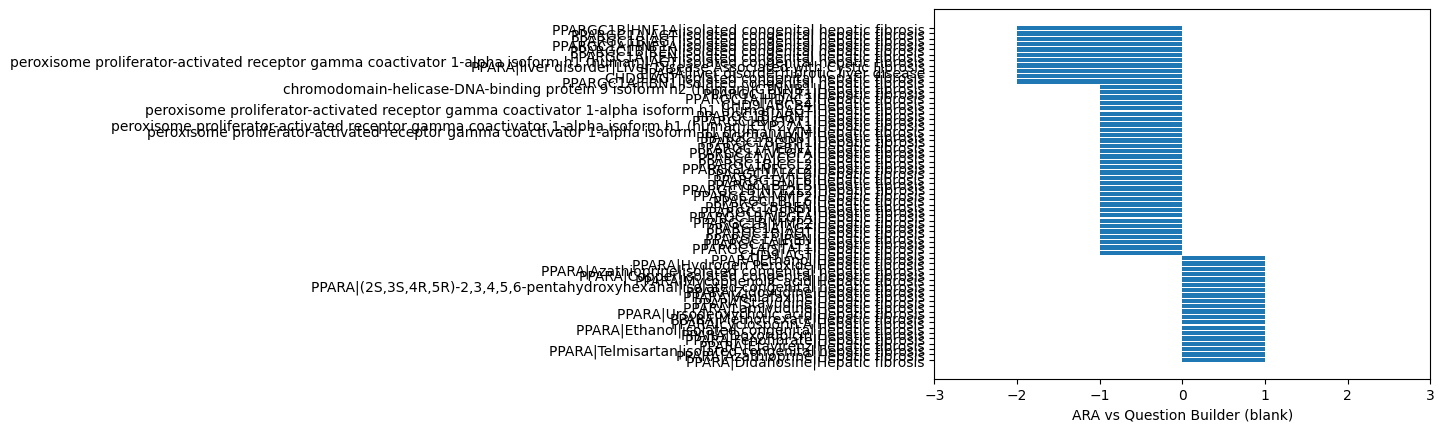

In [19]:
col1 = results_df_ARA.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)
col2 = results_df_qbuilder_blank.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)

label1 = "ARA"
label2 = "Question Builder (blank)"

pathways_in_common_list = list(set(col1) & set(col2))
pathways_col1_list = list(set(col1) - set(col2))
pathways_col2_list = list(set(col2) - set(col1))

venn2(subsets = (len(pathways_col1_list), len(pathways_col2_list), len(pathways_in_common_list)), set_labels = (label1, label2))
plt.show()

col3 = col1.value_counts()
col4 = col2.value_counts()

df_merge_input = pd.DataFrame([col3,col4]).T
df_merge_input.columns = [label1,label2]
df_merge_input[label1][df_merge_input[label1].isnull()] = 0
df_merge_input[label2][df_merge_input[label2].isnull()] = 0
df_merge_input_label1 = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] == 0)]
df_merge_input_label2 = df_merge_input[(df_merge_input[label1] == 0) & (df_merge_input[label2] > 0)]
df_merge_input_common = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] > 0)]
df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
df_merge_input_diff = df_merge_input[(df_merge_input[label1] == 0) | (df_merge_input[label2] == 0)]
df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]
print(f"Number of common pathways: {len(df_merge_input_common['set_difference'])}")
print(f"Number pathways in {label1} alone: {len(df_merge_input_label1[label1])}")
print(f"Number pathways in {label2} alone: {len(df_merge_input_label2[label2])}")
# display(df_merge_input_common)
display(df_merge_input_label1)
display(df_merge_input_label2)

y = df_merge_input_diff['set_difference']
x = df_merge_input_diff.index.values.tolist()
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()
plt.xlabel(f'{label1} vs {label2}')
max_set_difference = max(df_merge_input_diff['set_difference'])
min_set_difference = min(df_merge_input_diff['set_difference'])
plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])

In [18]:
# library and defining compare_results() function for later demo use
import matplotlib.pyplot as plt
import sys
from matplotlib_venn import venn2

def compare_results(df1, df2, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -df1: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -df2: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        # col1 = df1.apply(lambda row: '|'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        # col2 = df2.apply(lambda row: '|'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        col1 = df1.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)
        col2 = df2.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)

        pathways_in_common_list = list(set(col1) & set(col2))
        pathways_col1_list = list(set(col1) - set(col2))
        pathways_col2_list = list(set(col2) - set(col1))

        f.write("Common pathways:\n")
        for pathway in pathways_in_common_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for pathway in pathways_col1_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for pathway in pathways_col2_list:
            f.write(pathway)
            f.write("\n")
    
    venn2(subsets = (len(pathways_col1_list), len(pathways_col2_list), len(pathways_in_common_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    col3 = col1.value_counts()
    col4 = col2.value_counts()
        
    df_merge_input = pd.DataFrame([col3,col4]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input_label1 = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] == 0)]
    df_merge_input_label2 = df_merge_input[(df_merge_input[label1] == 0) & (df_merge_input[label2] > 0)]
    df_merge_input_common = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] > 0)]
    df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
    df_merge_input_diff = df_merge_input[(df_merge_input[label1] == 0) | (df_merge_input[label2] == 0)]
    df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]
    print(f"Number of common pathways: {len(df_merge_input_common['set_difference'])}")
    print(f"Number pathways in {label1} alone: {len(df_merge_input_label1[label1])}")
    print(f"Number pathways in {label2} alone: {len(df_merge_input_label2[label2])}")
    # display(df_merge_input_common)
    display(df_merge_input_label1)
    display(df_merge_input_label2)

    y = df_merge_input_diff['set_difference']
    x = df_merge_input_diff.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    max_set_difference = max(df_merge_input_diff['set_difference'])
    min_set_difference = min(df_merge_input_diff['set_difference'])
    plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")

        

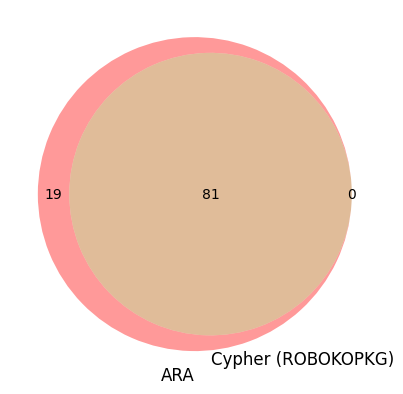

Number of common pathways: 81
Number pathways in ARA alone: 19
Number pathways in Cypher (ROBOKOPKG) alone: 0


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_21588\2272712304.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_21588\2272712304.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,ARA,Cypher (ROBOKOPKG)
peroxisome proliferator-activated receptor alpha isoform 1 (human)|AGT|isolated congenital hepatic fibrosis,6.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|IGFBP1|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|AGT|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|CNR2|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|CP|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|KRT18|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|CYP27A1|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|CCL2|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|CYP2R1|Hepatic fibrosis,3.0,0.0
peroxisome proliferator-activated receptor alpha isoform 1 (human)|F2|Hepatic fibrosis,3.0,0.0


,ARA,Cypher (ROBOKOPKG)


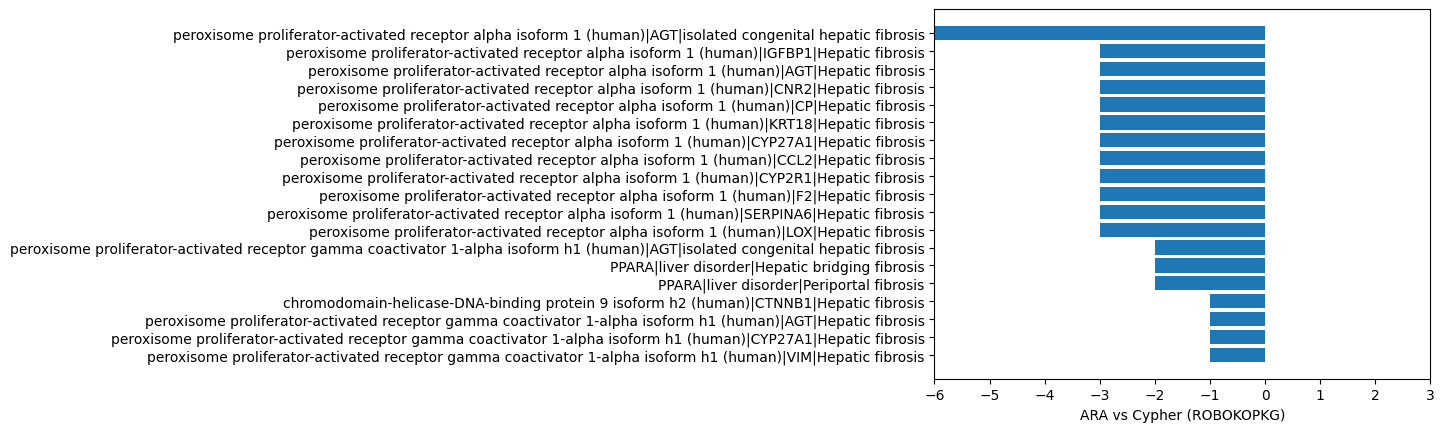

In [22]:
# ARA and Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_cypher-robokopkg.txt")
compare_results(results_df_ARA,results_df_Cypher_ROBOKOPKG, output_file_name, "ARA", "Cypher (ROBOKOPKG)")

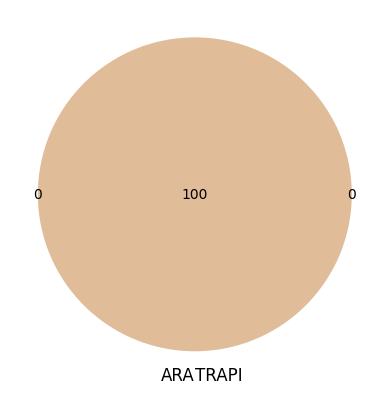

Number of common pathways: 100
Number pathways in ARA alone: 0
Number pathways in TRAPI alone: 0


,ARA,TRAPI


,ARA,TRAPI


ValueError: max() arg is an empty sequence

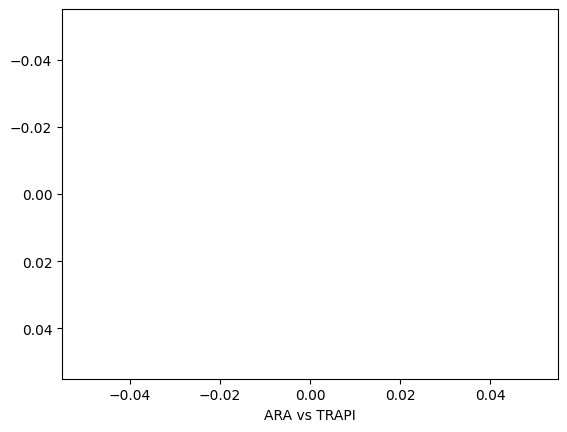

In [23]:
# ARA and TRAPI
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_trapi.txt")
compare_results(results_df_ARA,results_df_TRAPI, output_file_name, "ARA", "TRAPI")

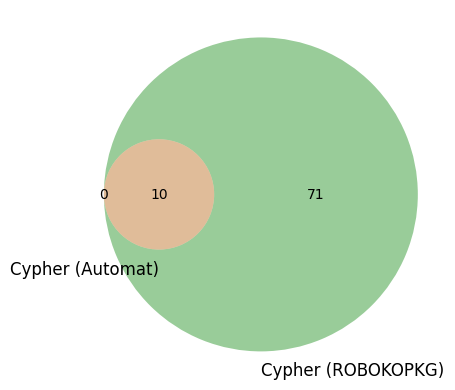

Number of common pathways: 10
Number pathways in Cypher (Automat) alone: 0
Number pathways in Cypher (ROBOKOPKG) alone: 71


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_21588\2272712304.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_21588\2272712304.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,Cypher (Automat),Cypher (ROBOKOPKG)


,Cypher (Automat),Cypher (ROBOKOPKG)
PPARGC1B|SPP1|Hepatic fibrosis,0.0,3.0
PPARA|SPP1|Hepatic fibrosis,0.0,3.0
PPARA|AGT|isolated congenital hepatic fibrosis,0.0,3.0
PPARA|ALB|Hepatic fibrosis,0.0,3.0
PPARA|AGT|Hepatic fibrosis,0.0,3.0
...,...,...
PPARGC1A|IL6|Hepatic fibrosis,0.0,1.0
PPARA|CNR2|Hepatic fibrosis,0.0,1.0
PPARGC1A|MMP2|Hepatic fibrosis,0.0,1.0
PPARGC1A|ARNT|Hepatic fibrosis,0.0,1.0


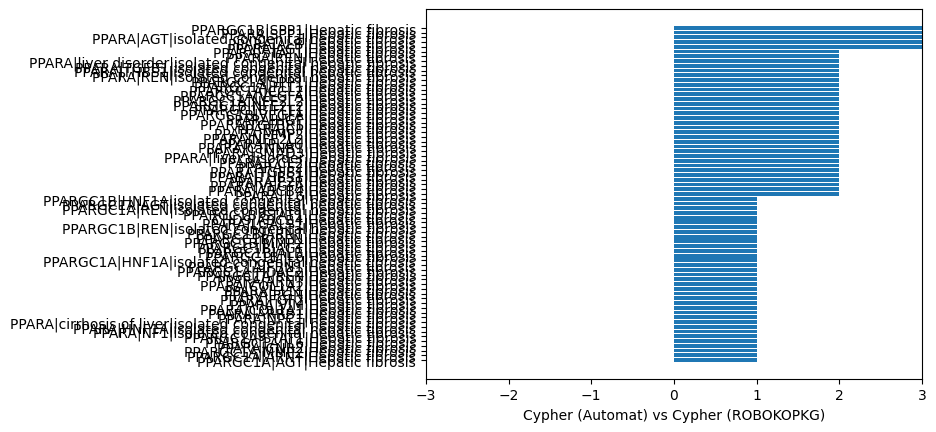

In [24]:
# Cypher (automat) and Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_cypher-automat_vs_cypher-robokopkg.txt")
compare_results(results_df_Cypher_Automat,results_df_Cypher_ROBOKOPKG, output_file_name, "Cypher (Automat)", "Cypher (ROBOKOPKG)")

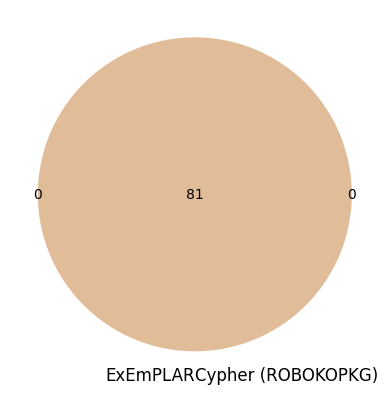

Number of common pathways: 81
Number pathways in ExEmPLAR alone: 0
Number pathways in Cypher (ROBOKOPKG) alone: 0


,ExEmPLAR,Cypher (ROBOKOPKG)


,ExEmPLAR,Cypher (ROBOKOPKG)


ValueError: max() arg is an empty sequence

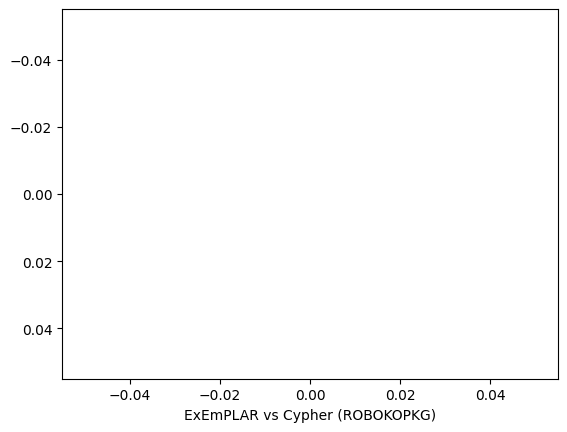

In [42]:
# ExEmPLAR and Cypher (robokopkg) sets
results_df_exemplar_names = results_df_exemplar[[c for c in results_df_exemplar.columns if "_name" in c]]
output_file_name = os.path.join(write_dir_compare,"compare_exemplar_vs_cypher-robokopkg.txt")
compare_results(results_df_exemplar_names,results_df_Cypher_ROBOKOPKG, output_file_name, "ExEmPLAR", "Cypher (ROBOKOPKG)")

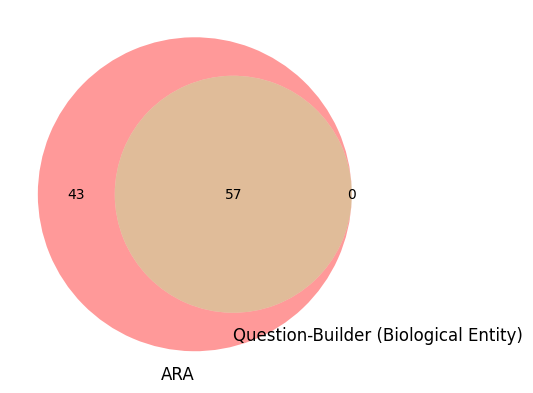

Number of common pathways: 57
Number pathways in ARA alone: 43
Number pathways in Question-Builder (Biological Entity) alone: 0


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_15804\2272712304.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_15804\2272712304.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,ARA,Question-Builder (Biological Entity)
PPARGC1B|HNF1A|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1B|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|HNF1A|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1B|REN|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|REN|isolated congenital hepatic fibrosis,2.0,0.0
peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARA|liver disorder|Liver Disease Associated with Cystic Fibrosis,2.0,0.0
PPARA|liver disorder|fibrotic liver disease,2.0,0.0
CHD9|AGT|isolated congenital hepatic fibrosis,2.0,0.0


,ARA,Question-Builder (Biological Entity)


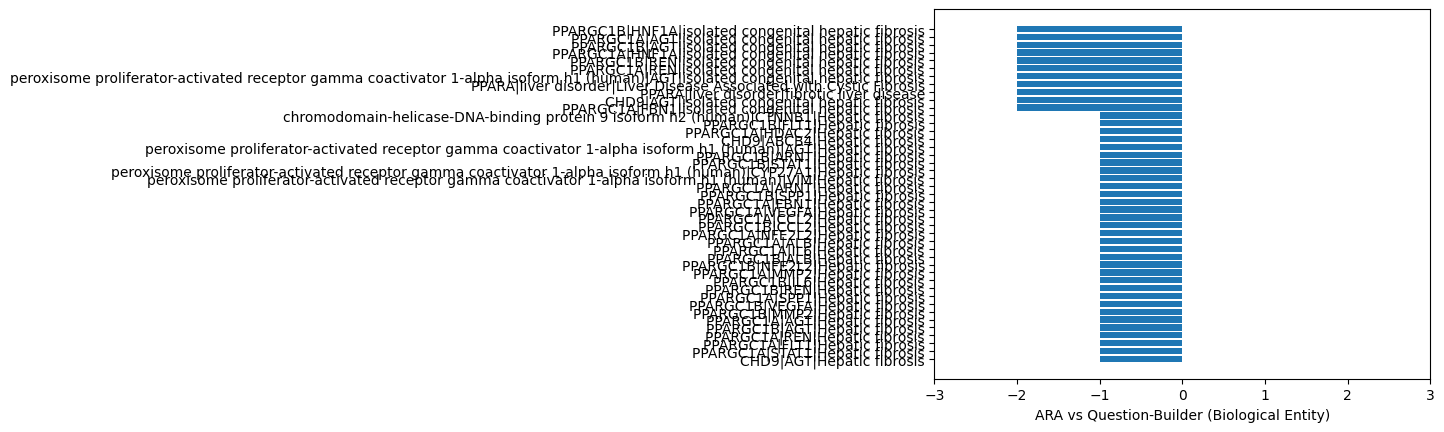

In [22]:
# ARA and Question Builder (Biological Entity) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_vs_qbuilder_bio_entity.txt")
compare_results(results_df_ARA,results_df_qbuilder_bio_entity, output_file_name, "ARA", "Question-Builder (Biological Entity)")

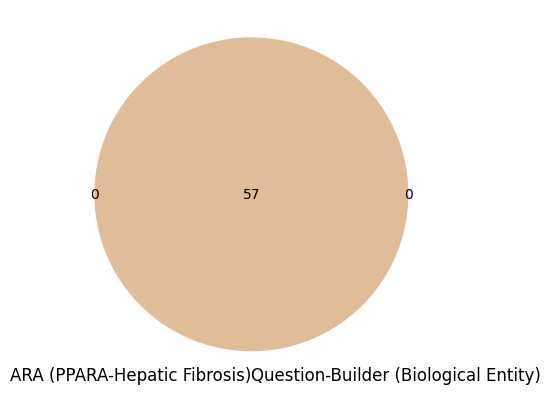

Number of common pathways: 57
Number pathways in ARA (PPARA-Hepatic Fibrosis) alone: 0
Number pathways in Question-Builder (Biological Entity) alone: 0


,ARA (PPARA-Hepatic Fibrosis),Question-Builder (Biological Entity)


,ARA (PPARA-Hepatic Fibrosis),Question-Builder (Biological Entity)


ValueError: max() arg is an empty sequence

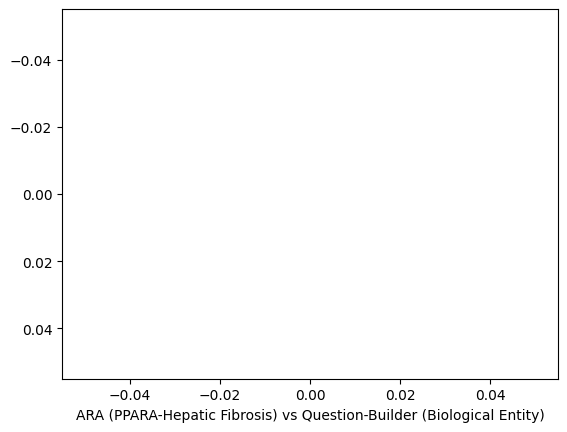

In [26]:
# ARA (PPARA-Hepatic Fibrosis) and Question Builder (Biological Entity) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_PPARA_Fibrosis_vs_qbuilder_bio_entity.txt")
compare_results(results_df_ARA_PPARA_Fibrosis,results_df_qbuilder_bio_entity, output_file_name, "ARA (PPARA-Hepatic Fibrosis)", "Question-Builder (Biological Entity)")

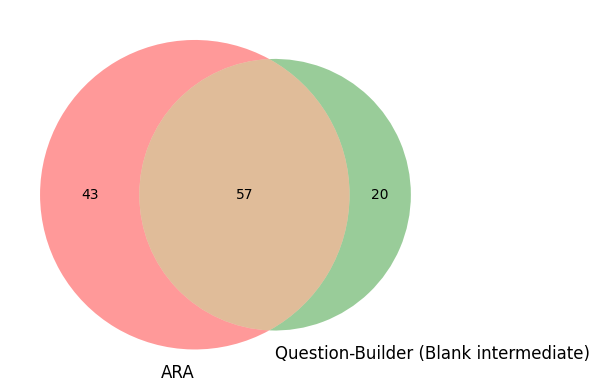

Number of common pathways: 57
Number pathways in ARA alone: 43
Number pathways in Question-Builder (Blank intermediate) alone: 20


C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_15804\2272712304.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
C:\Users\dnwilliams\AppData\Local\Temp\ipykernel_15804\2272712304.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]


,ARA,Question-Builder (Blank intermediate)
PPARGC1B|HNF1A|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1B|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|HNF1A|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1B|REN|isolated congenital hepatic fibrosis,2.0,0.0
PPARGC1A|REN|isolated congenital hepatic fibrosis,2.0,0.0
peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human)|AGT|isolated congenital hepatic fibrosis,2.0,0.0
PPARA|liver disorder|Liver Disease Associated with Cystic Fibrosis,2.0,0.0
PPARA|liver disorder|fibrotic liver disease,2.0,0.0
CHD9|AGT|isolated congenital hepatic fibrosis,2.0,0.0


,ARA,Question-Builder (Blank intermediate)
PPARA|Ethanol|Hepatic fibrosis,0.0,1.0
PPARA|Hydrogen Peroxide|Hepatic fibrosis,0.0,1.0
PPARA|Azathioprine|isolated congenital hepatic fibrosis,0.0,1.0
PPARA|Copper|isolated congenital hepatic fibrosis,0.0,1.0
PPARA|Mycophenolic acid|Hepatic fibrosis,0.0,1.0
"PPARA|(2S,3S,4R,5R)-2,3,4,5,6-pentahydroxyhexanal|isolated congenital hepatic fibrosis",0.0,1.0
PPARA|Zidovudine|Hepatic fibrosis,0.0,1.0
PPARA|Venlafaxine|Hepatic fibrosis,0.0,1.0
PPARA|Stavudine|Hepatic fibrosis,0.0,1.0
PPARA|Lamivudine|Hepatic fibrosis,0.0,1.0


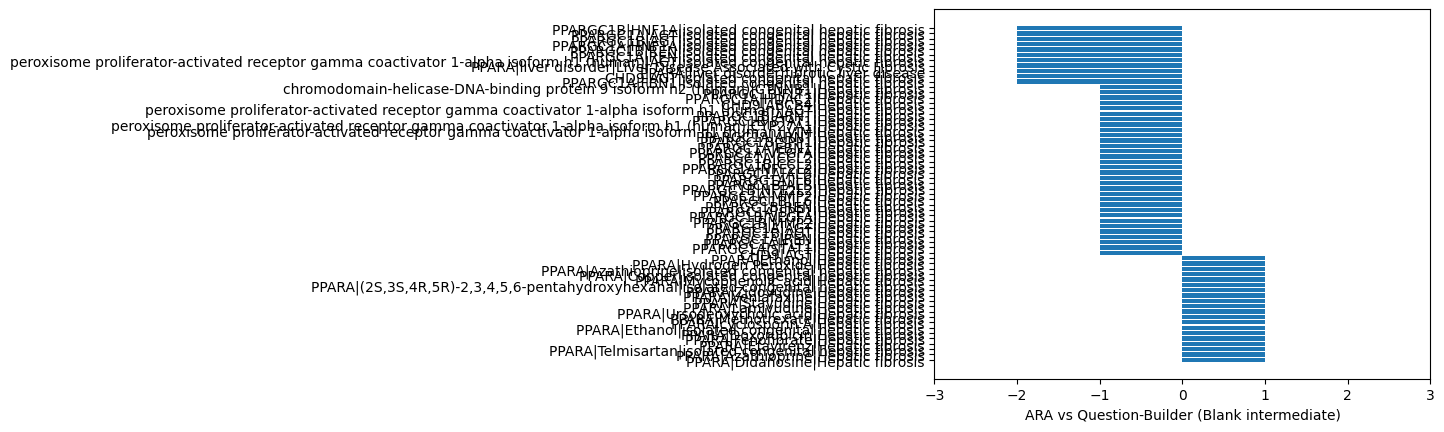

In [21]:
# ARA and Question Builder (Blank intermediate) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_vs_qbuilder_blank.txt")
compare_results(results_df_ARA,results_df_qbuilder_blank, output_file_name, "ARA", "Question-Builder (Blank intermediate)")